In [397]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Set dataset path
dataset_path = "PokemonData"

# Pre-processing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = ImageFolder(root=dataset_path, transform=transform)
labels = np.array([item[1] for item in dataset.samples])  # Class indices

# Stratified splits
train_indices, temp_indices = train_test_split(
    range(len(labels)), test_size=0.25, stratify=labels, random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=labels[temp_indices], random_state=42
)

# Optional: Reduce sizes (for debugging)
# train_indices = train_indices[:200]
# val_indices = val_indices[:100]
# test_indices = test_indices[:50]

# Create subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Encode labels (class names)
label_encoder = LabelEncoder()
label_encoder.fit(dataset.classes)  # Fit encoder to class names

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels[train_indices])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Summary
print(f"Classes: {dataset.classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Class weights: {class_weights}")


Classes: ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidok

In [399]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Train Loader Batches: {len(train_loader)}")
print(f"Validation Loader Batches: {len(val_loader)}")
print(f"Test Loader Batches: {len(test_loader)}")


Train Dataset Size: 5115
Validation Dataset Size: 852
Test Dataset Size: 853
Train Loader Batches: 160
Validation Loader Batches: 27
Test Loader Batches: 27


In [401]:
import pennylane as qml
import torch.nn as nn

n_qubits = 9
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the quantum circuit (encoding + convolutional layer)
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    # Encoding: Use rotation gates based on input data
    for i in range(n_qubits):
        qml.RX(inputs[i], wires=i)
        qml.RY(inputs[i], wires=i)
        qml.RZ(inputs[i], wires=i)

    # Random Quantum Circuit 
    num_layers = 3  # Increase the number of layers for a deeper circuit
    for _ in range(num_layers):
        for i in range(n_qubits):
            qml.RY(weights[i], wires=i)  # Parameterized rotation
        for i in range(n_qubits - 1):  # Add entanglement
            qml.CNOT(wires=[i, i + 1])

    # Measure the expectation values of each qubit
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    

# Quantum layer in PyTorch
class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        # Define trainable parameters for the quantum circuit
        self.weights = nn.Parameter(torch.randn(n_qubits, dtype=torch.float32))  # Trainable weights

    def forward(self, x):
        quantum_outputs = []
        for sample in x:
            sample_numpy = sample.detach().cpu().numpy()
            weights_numpy = self.weights.detach().cpu().numpy()
            output = torch.tensor(quantum_circuit(sample_numpy, weights_numpy), dtype=torch.float32, device=x.device)
            quantum_outputs.append(output)
        return torch.stack(quantum_outputs)

# Combined Model: ResNet-50 + Quantum Layer
class QuantumResNet(nn.Module):
    def __init__(self, num_classes):
        super(QuantumResNet, self).__init__()
        # Load ResNet-50 and remove its final classification layer
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  # Remove the classification head
        
        # Reduce ResNet output to match quantum input size
        self.fc_reduce = nn.Linear(2048, n_qubits)

        # Quantum Layer
        self.quantum_layer = QuantumLayer()

        # Final classification layer
        self.fc_output = nn.Sequential(
            nn.Dropout(0.5),  # Dropout to reduce overfitting
            nn.Linear(n_qubits, num_classes)
        )

    def forward(self, x):
        # ResNet Feature Extraction
        x = self.resnet(x)  # Shape: [batch_size, 2048, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, 2048]

        # Reduce features for Quantum Layer
        x = F.relu(self.fc_reduce(x))  # Shape: [batch_size, n_qubits]

        # Quantum Layer
        x = self.quantum_layer(x)  # Shape: [batch_size, n_qubits]

        # Classification Layer
        x = torch.softmax(self.fc_output(x), dim=1)  # Shape: [batch_size, num_classes]
        return x

In [21]:
pip install qiskit

  Using cached qiskit-1.2.4-cp38-abi3-win_amd64.whl.metadata (13 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached symengine-0.13.0-cp39-cp39-win_amd64.whl.metadata (1.2 kB)
  Using cached pbr-6.1.0-py2.py3-none-any.whl.metadata (3.4 kB)
Using cached qiskit-1.2.4-cp38-abi3-win_amd64.whl (4.6 MB)
Using cached dill-0.3.9-py3-none-any.whl (119 kB)
   ---------------------------------------- 0.0/17.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/17.8 MB ? eta -:--:--
    --------------------------------------- 0.3/17.8 MB ? eta -:--:--
   - -------------------------------------- 0.8/17.8 MB 2.1 MB/s eta 0:00:09
   -- ------------------------------------- 1.0/17.8 MB 1.9 MB/s eta 0:00:09
   -- ------------------------------------- 1.3/17.8 MB 1.7 MB/s eta 0:00:10
   --- ------------------------------------ 1.6/17.8 MB 1.6 MB/s eta 0:00:11
   ---- ----------------------------------- 1.8/17.8 MB 1.4 MB/s eta 0:00:12
   ---- ---------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\seher\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [403]:
import torch.nn as nn
import torch.nn.functional as F
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from torchvision import models


class QuantumCNN(nn.Module):
    def __init__(self, n_qubits=9):
        super(QuantumCNN, self).__init__()
        self.n_qubits = n_qubits  # Define the number of qubits

        # Classical Convolutional Layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # 64 filters
        self.pool1 = nn.MaxPool2d(2, 2)  # Downsample

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 128 filters
        self.pool2 = nn.MaxPool2d(2, 2)  # Downsample

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # 256 filters
        self.pool3 = nn.MaxPool2d(2, 2)  # Downsample

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)  # 512 filters
        self.pool4 = nn.MaxPool2d(2, 2)
        
        # After convolution and pooling, the output size is reduced. Adjust based on input image size.
        # Assuming input size of 28x28, after 4 pooling layers the output size would be 512x1x1
        self.reduce_to_qubits = nn.Linear(512 * 1 * 1, n_qubits)

        # Quantum layer (needs implementation)
        self.quantum_layer = QuantumLayer()

        # Classification layer
        self.fc_output = nn.Linear(n_qubits, 150)  # Assuming 151 classes for classification

    def forward(self, x):
        # Classical Convolutional Layers
        x = self.pool1(F.relu(self.conv1(x)))  # Shape: [batch_size, 64, height, width]
        x = self.pool2(F.relu(self.conv2(x)))  # Shape: [batch_size, 128, height, width]
        x = self.pool3(F.relu(self.conv3(x)))  # Shape: [batch_size, 256, height, width]
        x = self.pool4(F.relu(self.conv4(x)))  # Shape: [batch_size, 512, height, width]

        # Flatten the output dynamically
        x = x.view(x.size(0), -1)  # Shape: [batch_size, flattened_features]
        print(f"Shape before quantum layer: {x.shape}")
    
        # Fully Connected Layer to reduce dimensions for Quantum Layer
        x = F.relu(self.reduce_to_qubits(x))  # Shape: [batch_size, n_qubits]
        
        # Quantum Layer
        x = self.quantum_layer(x)  # Shape: [batch_size, n_qubits]
        print(f"Shape after quantum layer: {x.shape}")

        # Fully connected classification layer
        x = torch.softmax(self.fc_output(x), dim=1)  # Shape: [batch_size, num_classes]
        return x


# Initialize the model
num_classes = 150  # Number of Pokémon classes
model = QuantumResNet(num_classes).to(device)  # Number of Pokémon classes
inputs = torch.rand(32, 3, 28, 28).to(device)  # Example input size (batch_size, channels, height, width)

# Test forward pass
outputs = model(inputs)
print(f"Output shape: {outputs.shape}")


C:\Users\seher\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\seher\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([32, 150])


In [269]:
pip install pylatexenc


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\seher\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


0: ──RX(M0)──RY(M0)──RZ(M0)──RY(1.00)─╭●──RY(1.00)───────────╭●─────────RY(1.00)───────────╭●───────
1: ──RX(M1)──RY(M1)──RZ(M1)──RY(1.00)─╰X─╭●─────────RY(1.00)─╰X────────╭●─────────RY(1.00)─╰X───────
2: ──RX(M2)──RY(M2)──RZ(M2)──RY(1.00)────╰X────────╭●─────────RY(1.00)─╰X────────╭●─────────RY(1.00)
3: ──RX(M3)──RY(M3)──RZ(M3)──RY(1.00)──────────────╰X────────╭●─────────RY(1.00)─╰X────────╭●───────
4: ──RX(M4)──RY(M4)──RZ(M4)──RY(1.00)────────────────────────╰X────────╭●─────────RY(1.00)─╰X───────
5: ──RX(M5)──RY(M5)──RZ(M5)──RY(1.00)──────────────────────────────────╰X────────╭●─────────RY(1.00)
6: ──RX(M6)──RY(M6)──RZ(M6)──RY(1.00)────────────────────────────────────────────╰X────────╭●───────
7: ──RX(M7)──RY(M7)──RZ(M7)──RY(1.00)──────────────────────────────────────────────────────╰X───────
8: ──RX(M8)──RY(M8)──RZ(M8)──RY(1.00)───────────────────────────────────────────────────────────────

──────────────────────────────────────────────────────────┤  <Z>
──╭●─────────────────────

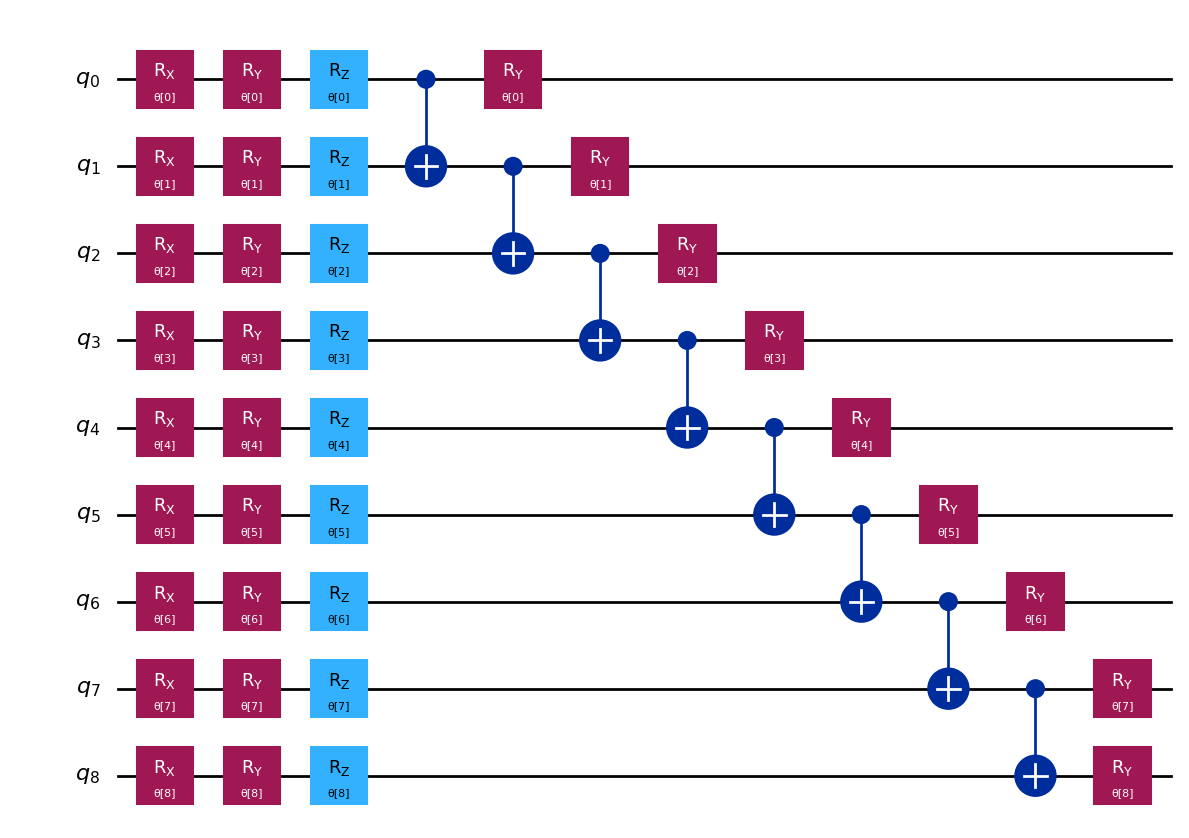

In [404]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import matplotlib.pyplot as plt

print(qml.draw(quantum_circuit)(inputs, weights))  # Pennylane visualization

# Define Qiskit quantum circuit based on the Pennylane one
params = ParameterVector('θ', length=n_qubits)
qiskit_circuit = QuantumCircuit(n_qubits)

# Add parameterized RX gates
for i in range(n_qubits):
    qiskit_circuit.rx(params[i], i)

for i in range(n_qubits):
    qiskit_circuit.ry(params[i], i)

for i in range(n_qubits):
    qiskit_circuit.rz(params[i], i)

# Add CNOT gates
for i in range(n_qubits - 1):
    qiskit_circuit.cx(i, i + 1)
for i in range(n_qubits):
    qiskit_circuit.ry(params[i], i)


# Draw the Qiskit circuit
fig, ax = plt.subplots(figsize=(12, 12))
qiskit_circuit.draw("mpl", style="default", ax=ax)
plt.tight_layout()
plt.show()


In [407]:
for inputs, labels in train_loader:
    print(f"Input batch size: {inputs.shape[0]}, Label batch size: {labels.shape[0]}")
    # Send data to device
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    break


Input batch size: 32, Label batch size: 32


In [368]:
for inputs, labels in train_loader:
    print(f"Train batch size: {inputs.size(0)}")
    break
    

Train batch size: 32


In [408]:
print("Unique labels in train_labels:", np.unique(labels))



Unique labels in train_labels: [  7  10  15  17  20  22  23  29  37  42  43  44  48  52  67  78  80  82
  84  94  97 102 108 109 137 139 148 149]


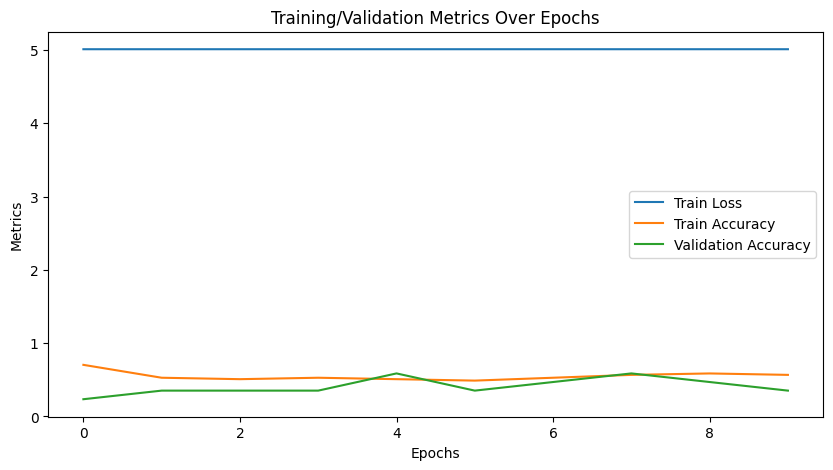

In [413]:
import torch.optim as optim
import matplotlib.pyplot as plt


# Send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training setup

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loss_values = []  # Store training loss values
train_accuracy_values = []  # Store training accuracy
val_accuracy_values = []  # Store validation accuracy

# Early stopping setup
patience = 5  # Number of epochs to wait before stopping
best_val_accuracy = 0
early_stop_counter = 0
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)



# Training loop
num_epochs = 10  
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        # Send data to device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        
     # Calculate and store training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            # Send data to device
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val += (val_predicted == val_labels).sum().item()
            total_val += val_labels.size(0)

    # Calculate and store validation accuracy
    val_accuracy = 100 * correct_val / total_val
    val_accuracy_values.append(val_accuracy)

    scheduler.step(val_accuracy)
    
    # Early stopping check
    if val_accuracy >= best_val_accuracy:
        best_val_accuracy = val_accuracy
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    # print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    # print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Plot training/validation metrics
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label="Train Loss")
plt.plot(train_accuracy_values, label="Train Accuracy")
plt.plot(val_accuracy_values, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.title("Training/Validation Metrics Over Epochs")
plt.show()

In [395]:
from collections import Counter
print(Counter(labels))  # labels from your dataset


Counter({tensor(125): 1, tensor(45): 1, tensor(78): 1, tensor(25): 1, tensor(78): 1, tensor(147): 1, tensor(44): 1, tensor(144): 1, tensor(71): 1, tensor(67): 1, tensor(21): 1, tensor(139): 1, tensor(101): 1, tensor(112): 1, tensor(137): 1, tensor(51): 1, tensor(111): 1, tensor(136): 1, tensor(74): 1, tensor(16): 1, tensor(51): 1})


In [415]:

correct_test = 0
total_test = 0
all_test_labels = []
all_test_predictions = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)

        correct_test += (test_predicted == test_labels).sum().item()
        total_test += test_labels.size(0)
        all_test_labels.extend(test_labels.cpu().numpy())
        all_test_predictions.extend(test_predicted.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 0.59%


In [49]:
print(f"Number of classes: {len(set(labels))}")
for inputs, labels in train_loader:
    print(f"Batch labels: {labels}")
    break
print(f"Output layer size: {model.fc_output.out_features}")
max_label = max([max(labels.tolist()) for _, labels in train_loader])
print(f"Max label in dataset: {max_label}")

Number of classes: 8
Batch labels: tensor([  2,  79,  12,  75,  15,  82, 105,  90, 130,  47,  79, 128, 111, 108,
          0,   7,  44, 136, 108, 138, 119, 139,  43,  78, 115, 142,  97,  52,
         38,  32, 138, 108])
Output layer size: 150
Max label in dataset: 149


In [427]:
# Function to make predictions
from PIL import Image
def predict_pokemon(image_path):
    # Load and preprocess the input image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Perform prediction
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        pokemon_class = label_encoder.inverse_transform([predicted.item()])[0]
    
    # Output the class
    return pokemon_class

# Example usage
predicted_pokemon = predict_pokemon('jiggles.jpeg')
print(f'Predicted Pokémon: {predicted_pokemon}')


Predicted Pokémon: Flareon


In [306]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image
import torch
import torchvision.transforms as transforms

# Load the model and label encoder
# (Ensure these are properly defined and loaded in your main script)
# model = <your_trained_model>
# label_encoder = <your_label_encoder>

# Preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((28, 28)),          # Resize to 28x28 pixels
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize to range [-1, 1]
])

# Function to predict Pokémon from an image
def predict_pokemon(image_path):
    try:
        # Load and preprocess the input image
        image = Image.open(image_path) # Convert to grayscale
        image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Perform prediction
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            pokemon_class = label_encoder.inverse_transform([predicted.item()])[0]

        # Output the class
        return pokemon_class
    except Exception as e:
        print(f"Error during prediction: {e}")
        return "Error"

# Function to open file picker dialog
def select_file():
    file_path = filedialog.askopenfilename(
        title="Select an Image",
        filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")]
    )
    if file_path:
        print(f"Selected file: {file_path}")
        # Predict and display Pokémon name
        predicted_pokemon = predict_pokemon(file_path)
        print(f'Predicted Pokémon: {predicted_pokemon}')

# Create a simple GUI for file selection
def create_interface():
    root = tk.Tk()
    root.title("Pokémon Predictor")

    # Button to open file picker
    select_button = tk.Button(root, text="Select Image", command=select_file)
    select_button.pack(pady=20)

    # Label to provide instructions
    instructions = tk.Label(root, text="Click the button to select a Pokémon image.")
    instructions.pack(pady=10)

    root.mainloop()

# Run the interface
create_interface()


In [431]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import numpy as np

# Ensure your model is in evaluation mode
model.eval()

# Placeholder for predictions and true labels
all_predictions = []
all_true_labels = []

# Run inference on the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Perform inference
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)

        # Collect predictions and true labels
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Compute metrics
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions, average='weighted', zero_division=1)
recall = recall_score(all_true_labels, all_predictions, average='weighted', zero_division=1)
f1 = f1_score(all_true_labels, all_predictions, average='weighted', zero_division=1)


# Print results
print("Predictions:", all_predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

from collections import Counter

print("True label distribution:", Counter(all_true_labels))
print("Predicted label distribution:", Counter(all_predictions))



Predictions: [39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 86 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 86 39 39 39 39 39 39 39 39 39 39 39 39 64 39 39
 39 39 39 39 39 39 39 39 39 39 64 39 39 39 39 39 39 39 39 39 39 39 39 64
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 64 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 86 39 39 39 39 39 39 86
 39 39 39 86 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 86 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 3